,BND,SPY,TSLA,BND_ret,SPY_ret,TSLA_ret,BND_logret,SPY_logret,TSLA_logret
Date,,,,,,,,,
2025-07-24,72.698860,634.419983,305.299988,-0.001232,0.000331,-0.081970,-0.001233,0.000331,-0.085525
2025-07-25,72.878265,637.099976,316.059998,0.002468,0.004224,0.035244,0.002465,0.004215,0.034637
2025-07-28,72.758659,636.940002,325.589996,-0.001641,-0.000251,0.030152,-0.001643,-0.000251,0.029707
2025-07-29,73.137398,635.260010,321.200012,0.005205,-0.002638,-0.013483,0.005192,-0.002641,-0.013575
2025-07-30,72.948036,634.460022,319.040009,-0.002589,-0.001259,-0.006725,-0.002592,-0.001260,-0.006748


ARIMA order: (2, 0, 2)


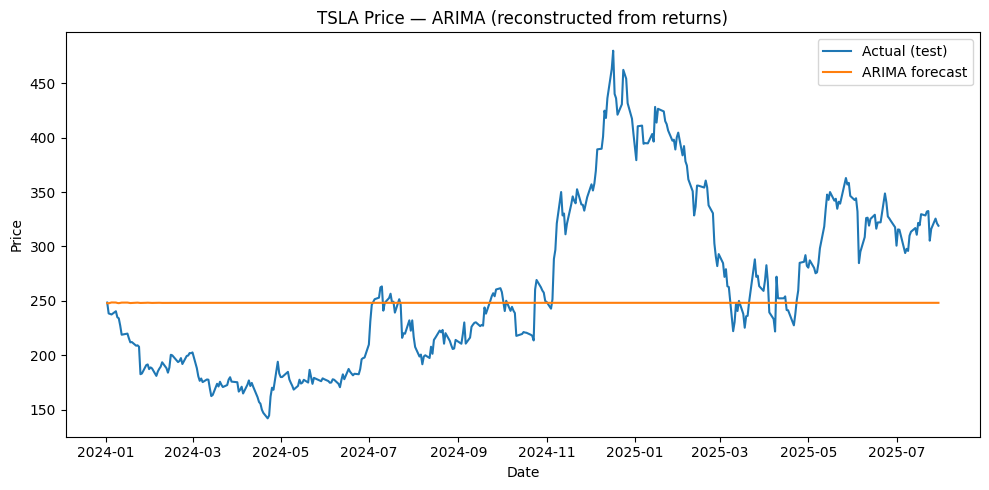

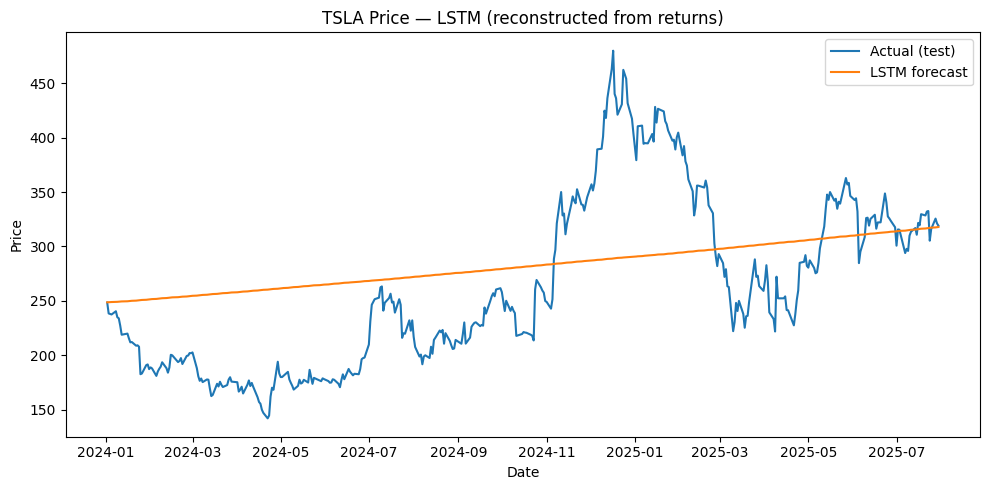

In [3]:
from pathlib import Path
import sys, importlib, warnings
warnings.filterwarnings("ignore")

# repo root
cwd = Path().resolve()
repo_root = None
for p in [cwd, *cwd.parents]:
    if (p / "src").is_dir():
        repo_root = p
        break
assert repo_root, "Cannot find repo root with 'src/'"
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import src.config, src.splits, src.models.arima_model, src.models.lstm_model, src.utils.metrics
importlib.reload(src.config); importlib.reload(src.splits)
importlib.reload(src.models.arima_model); importlib.reload(src.models.lstm_model)
importlib.reload(src.utils.metrics)

from src.config import Settings
from src.splits import TimeSeriesSplitter
from src.models.arima_model import ARIMAModel
from src.models.lstm_model import LSTMModel, TENSORFLOW_AVAILABLE
from src.utils.metrics import Metrics

cfg = Settings()
cfg

# Load the dataset from Task 1
df = pd.read_csv(cfg.data_processed_dir / "merged_features.csv", parse_dates=["Date"]).set_index("Date")
display(df.tail())

# We'll model TSLA log returns (stationary). Keep a copy of actual prices for reconstruction.
ret_series = df["TSLA_logret"].dropna()
price_series = df["TSLA"].dropna()

# Train/test split (chronological)
splitter = TimeSeriesSplitter(train_end="2023-12-31", test_start="2024-01-01")
ret_train, ret_test = splitter.split(ret_series)
price_train, price_test = splitter.split(price_series)

len(ret_train), len(ret_test), price_train.index.max(), price_test.index.min()


# --- Clean ARIMA block: no freq warnings, tidy output ---
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Silence noisy warnings
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency")
warnings.filterwarnings("ignore", message="No supported index is available")

# 1) Work on integer indices for model fit
ret_train_i = ret_train.copy()
ret_test_i  = ret_test.copy()
ret_train_i.index = pd.RangeIndex(len(ret_train_i))
ret_test_i.index  = pd.RangeIndex(len(ret_test_i))

# 2) Fit ARIMA on returns (trend 'n' is standard for returns)
arima = ARIMAModel(grid_p=range(0,4), grid_d=range(0,2), grid_q=range(0,4), trend="n").fit(ret_train_i)

# 3) Forecast same number of steps as test
ret_pred_arima = arima.forecast(len(ret_test_i))

# 4) Reattach your real test dates for downstream alignment & plotting
ret_pred_arima = pd.Series(ret_pred_arima, index=ret_test.index)

# 5) Metrics on returns
arima_ret_mae  = Metrics.mae(ret_test.values, ret_pred_arima.values)
arima_ret_rmse = Metrics.rmse(ret_test.values, ret_pred_arima.values)
arima_ret_mape = Metrics.mape(ret_test.values, ret_pred_arima.values)

# 6) Reconstruct price path from last train price
last_train_price = price_train.iloc[-1]
price_pred_arima = last_train_price * (1.0 + ret_pred_arima.values).cumprod()
price_true_aligned = price_test.iloc[:len(price_pred_arima)]

arima_px_mae  = Metrics.mae(price_true_aligned.values, price_pred_arima)
arima_px_rmse = Metrics.rmse(price_true_aligned.values, price_pred_arima)
arima_px_mape = Metrics.mape(price_true_aligned.values, price_pred_arima)

print("ARIMA order:", arima.order)
{
 "ARIMA_ret": (arima_ret_mae, arima_ret_rmse, arima_ret_mape),
 "ARIMA_px":  (arima_px_mae,  arima_px_rmse,  arima_px_mape),
}


if TENSORFLOW_AVAILABLE:
    lstm = LSTMModel(lookback=60, units=64, dropout=0.2, seed=42)
    lstm.fit(ret_train, epochs=30, batch_size=32, verbose=0)
    ret_pred_lstm = lstm.forecast(ret_train, steps=len(ret_test))

    lstm_ret_mae  = Metrics.mae(ret_test.values, ret_pred_lstm)
    lstm_ret_rmse = Metrics.rmse(ret_test.values, ret_pred_lstm)
    lstm_ret_mape = Metrics.mape(ret_test.values, ret_pred_lstm)

    price_pred_lstm = last_train_price * np.cumprod(1.0 + ret_pred_lstm)
    lstm_px_mae  = Metrics.mae(price_true_aligned.values, price_pred_lstm)
    lstm_px_rmse = Metrics.rmse(price_true_aligned.values, price_pred_lstm)
    lstm_px_mape = Metrics.mape(price_true_aligned.values, price_pred_lstm)

    {
     "LSTM_ret": (lstm_ret_mae, lstm_ret_rmse, lstm_ret_mape),
     "LSTM_px":  (lstm_px_mae,  lstm_px_rmse,  lstm_px_mape)
    }
else:
    print("TensorFlow not available; skipping LSTM.")

fig_dir = cfg.reports_figures_dir
fig_dir.mkdir(parents=True, exist_ok=True)

# ARIMA price forecast vs actual
plt.figure(figsize=(10,5))
plt.plot(price_true_aligned.index, price_true_aligned.values, label="Actual (test)")
plt.plot(price_true_aligned.index, price_pred_arima, label="ARIMA forecast")
plt.title("TSLA Price — ARIMA (reconstructed from returns)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.tight_layout()
plt.savefig(fig_dir / "tsla_pred_price_arima.png"); plt.show()

# LSTM price forecast vs actual (if available)
if TENSORFLOW_AVAILABLE:
    plt.figure(figsize=(10,5))
    plt.plot(price_true_aligned.index, price_true_aligned.values, label="Actual (test)")
    plt.plot(price_true_aligned.index, price_pred_lstm, label="LSTM forecast")
    plt.title("TSLA Price — LSTM (reconstructed from returns)")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend(); plt.tight_layout()
    plt.savefig(fig_dir / "tsla_pred_price_lstm.png"); plt.show()




In [4]:
rows = []
rows.append({
    "model":"ARIMA",
    "ret_MAE": arima_ret_mae, "ret_RMSE": arima_ret_rmse, "ret_MAPE": arima_ret_mape,
    "px_MAE":  arima_px_mae,  "px_RMSE":  arima_px_rmse,  "px_MAPE":  arima_px_mape
})
if TENSORFLOW_AVAILABLE:
    rows.append({
        "model":"LSTM",
        "ret_MAE": lstm_ret_mae, "ret_RMSE": lstm_ret_rmse, "ret_MAPE": lstm_ret_mape,
        "px_MAE":  lstm_px_mae,  "px_RMSE":  lstm_px_rmse,  "px_MAPE":  lstm_px_mape
    })

metrics_df = pd.DataFrame(rows)
display(metrics_df)

out_csv = fig_dir.parent / "interim" / "task2_metrics.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
metrics_df.to_csv(out_csv, index=False)
print("Saved metrics CSV:", out_csv)

# pick the best by price RMSE
best = metrics_df.sort_values("px_RMSE").iloc[0]
print("Best model by price RMSE on test:", dict(best))


,model,ret_MAE,ret_RMSE,ret_MAPE,px_MAE,px_RMSE,px_MAPE
0,ARIMA,0.030346,0.042038,102.089479,62.963346,78.011549,24.059325
1,LSTM,0.030353,0.042036,103.497073,57.692547,67.545306,24.614230


Saved metrics CSV: ..\reports\interim\task2_metrics.csv
Best model by price RMSE on test: {'model': 'LSTM', 'ret_MAE': np.float64(0.030352615276703406), 'ret_RMSE': np.float64(0.04203591095960789), 'ret_MAPE': np.float64(103.49707314287495), 'px_MAE': np.float64(57.692547229602006), 'px_RMSE': np.float64(67.54530641571837), 'px_MAPE': np.float64(24.614229606495527)}
